In [1]:
import numpy as np
import torch
import torchvision
import pandas as pd
import resnet_kaggle_test
from torch import nn
from d2l import torch as d2l
from torch.utils import data
from leaf_data_set import LeafDataset
  

In [2]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.RandomVerticalFlip(),
     torchvision.transforms.RandomRotation(180, fill=(255,255,255)),
     torchvision.transforms.ColorJitter(
          brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
     torchvision.transforms.ToTensor()])

test_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])
leaf_train_dataset = LeafDataset('train.csv',transform=train_augs)
leaf_test_dataset = LeafDataset('test.csv', transform= test_aug, train = False)

In [3]:
batch_size = 256
leaf_train_data_loader = data.DataLoader(leaf_train_dataset, batch_size=batch_size, shuffle= True, num_workers= 4)
leaf_test_data_loader = data.DataLoader(leaf_test_dataset, batch_size=batch_size, shuffle= False, num_workers= 4)

# from torchvision.io import write_jpeg
# trans = torchvision.transforms.ToPILImage()
# for i, (X, y) in enumerate(leaf_train_data_loader):
#     # d2l.plt.imshow(encode_jpeg())
#     d2l.plt.imshow(trans(torch.squeeze(X)))
#     if i == 2:
#         break

In [4]:
block_1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 7, stride=2, padding = 3),
                        nn.BatchNorm2d(64), nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

block_2 = nn.Sequential(*resnet_kaggle_test.resnet_block(64, 64, 2, True)) # 56
block_3 = nn.Sequential(*resnet_kaggle_test.resnet_block(64, 128, 2))  # 28
block_4 = nn.Sequential(*resnet_kaggle_test.resnet_block(128,256, 2))  # 14
block_5 = nn.Sequential(*resnet_kaggle_test.resnet_block(256,512, 2))  # 7


res_net_v1 = nn.Sequential(block_1, block_2, block_3, block_4, block_5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(512, 176))


In [14]:
X = torch.randn(128,3,224,224)
for layer in res_net_v1:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([128, 64, 56, 56])
Sequential output shape:	 torch.Size([128, 64, 56, 56])
Sequential output shape:	 torch.Size([128, 128, 28, 28])
Sequential output shape:	 torch.Size([128, 256, 14, 14])
Sequential output shape:	 torch.Size([128, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([128, 512, 1, 1])
Flatten output shape:	 torch.Size([128, 512])
Linear output shape:	 torch.Size([128, 176])


In [5]:
def init_weight(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

def train(net, train_data, num_epochs, lr, device):
    net.to(device)
    net.apply(init_weight)

    print('training on', device)
    
    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr = lr)
    timer, num_batches = d2l.Timer(), len(train_data)
    print('num batches', num_batches)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    
    for num_epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for i, (X,y) in enumerate(train_data):
            timer.start()
            trainer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()

            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(num_epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

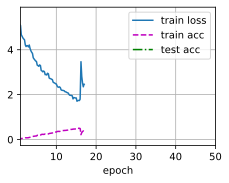

In [6]:
lr, num_epochs = 0.05, 50
train(res_net_v1, leaf_train_data_loader, num_epochs, lr, d2l.try_gpu())

In [66]:
torch.save(res_net_v1, 'res_net_v3.pt')

In [73]:
res_net = torch.load('res_net_v3.pt')
res_net.to(d2l.try_gpu())

enable_decode = False

test_pred = []
for i, (X, y) in enumerate(leaf_test_data_loader):
    X = X.to(d2l.try_gpu())
    pred_batch = res_net(X)
    if enable_decode:
        pred_batch = leaf_train_dataset.le.classes_[d2l.argmax(pred_batch, axis=1).to('cpu').numpy()]
        test_pred = test_pred + pred_batch.tolist()
    else:
        pred_batch = d2l.argmax(pred_batch, axis=1).to('cpu').numpy()
        for pred in pred_batch:
            test_pred.append(leaf_train_dataset.rev_category_dict[pred])

In [71]:
res_net = torch.load('res_net_v3.pt')
res_net.to(d2l.try_gpu())

loss = nn.CrossEntropyLoss()
leaf_train_data_loader_test = data.DataLoader(leaf_train_dataset, batch_size=256, shuffle= False, num_workers= 4)

enable_decode = False
test_pred = []
metric = d2l.Accumulator(3)
with torch.no_grad():
    for i, (X, y) in enumerate(leaf_train_data_loader_test):
        X = X.to(d2l.try_gpu())
        y = y.to(d2l.try_gpu())
        pred_batch = res_net_v1(X)
        if enable_decode:
            print(y)
            print(loss(pred_batch, y))
            pred_batch = d2l.argmax(pred_batch, axis=1).to('cpu').numpy()
            pred_batch = leaf_train_dataset.le.classes_[pred_batch]
            # test_pred = test_pred + pred_batch.tolist()
        else:
            # print(y)
            # print(loss(pred_batch, y))
            l = loss(pred_batch, y)
            metric.add(l * X.shape[0], d2l.accuracy(pred_batch, y), X.shape[0])
            # pred_batch = d2l.argmax(pred_batch, axis=1).to('cpu').numpy()
            # for pred in pred_batch:
            #     test_pred.append(leaf_train_dataset.rev_category_dict[pred])
    print(metric[0]/ metric[2])

0.5837009849583674


In [74]:
test_data = dict()
test_data['label'] = pd.Series(test_pred, name='label')
test_data['image'] = leaf_test_dataset.data_list.image
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv('submission_3.csv', index=False)

# preds = res_net_v1(test_features).detach().numpy()
# # 将其重新格式化以导出到Kaggle
# test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
# submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
# submission.to_csv('submission.csv', index=False)